In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/insurance.csv')

In [3]:
df.drop_duplicates(inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1337 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1337 non-null   int64  
 1   sex       1337 non-null   object 
 2   bmi       1337 non-null   float64
 3   children  1337 non-null   int64  
 4   smoker    1337 non-null   object 
 5   region    1337 non-null   object 
 6   charges   1337 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 83.6+ KB


In [5]:
df.shape

(1337, 7)

In [6]:
# Adding age ranges
# 0-30 -> young, 30-60 -> mid, 60-100 -> old

df['age_range'] = 'young'
df.loc[(df['age'] > 30) & (df['age'] <= 60), 'age_range'] = 'mid'
df.loc[(df['age'] > 60), 'age_range'] = 'old'
df.head()

,age,sex,bmi,children,smoker,region,charges,age_range
0,19,female,27.900,0,yes,southwest,16884.92400,young
1,18,male,33.770,1,no,southeast,1725.55230,young
2,28,male,33.000,3,no,southeast,4449.46200,young
3,33,male,22.705,0,no,northwest,21984.47061,mid
4,32,male,28.880,0,no,northwest,3866.85520,mid


In [7]:
# Bmi ranges
# bmi < 18.5 -> underweight, 18.5-24.9 -> normal, 25.0-29.9 -> overweight, >30.0 -> obese

df['bmi_range'] = 'underweight'
df.loc[(df['bmi'] >= 18.5) & (df['bmi'] < 25.0), 'bmi_range'] = 'normal'
df.loc[(df['bmi'] >= 25.0) & (df['bmi'] < 30.0), 'bmi_range'] = 'overweight'
df.loc[(df['bmi'] >= 30.0), 'bmi_range'] = 'obese'

df.head()

,age,sex,bmi,children,smoker,region,charges,age_range,bmi_range
0,19,female,27.900,0,yes,southwest,16884.92400,young,overweight
1,18,male,33.770,1,no,southeast,1725.55230,young,obese
2,28,male,33.000,3,no,southeast,4449.46200,young,obese
3,33,male,22.705,0,no,northwest,21984.47061,mid,normal
4,32,male,28.880,0,no,northwest,3866.85520,mid,overweight


In [8]:
X = df.drop(columns=['charges', 'bmi','age'])
Y = df['charges']

num_features = X.select_dtypes(exclude='object').columns
cat_features = X.select_dtypes(include='object').columns

oh_encoder = OneHotEncoder()
scalar = StandardScaler()

preprocessor = ColumnTransformer(
    [
        ('OneHotEncoder', oh_encoder, cat_features),
        ('StandardScaler', scalar, num_features)
    ]
)

In [9]:
print(num_features)
print (cat_features)

Index(['children'], dtype='object')
Index(['sex', 'smoker', 'region', 'age_range', 'bmi_range'], dtype='object')


In [10]:
X = preprocessor.fit_transform(X)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((1069, 16), (268, 16))

In [12]:
# Function to evaluate the model

def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    r2 = r2_score(true, predicted)
    rmse = np.sqrt(mse)
    return mae, mse, r2, rmse

In [13]:
# Models we are going to use

models = {
    "LinearRegression" : LinearRegression(),
    "Lasso" : Lasso(),
    "Ridge" : Ridge(),
    "K-Neighbors Regressor" : KNeighborsRegressor(),
    "Decision Tree" : DecisionTreeRegressor(),
    "XGBRegressor" : XGBRegressor(),
    "CatBoost Regressor" : CatBoostRegressor(),
    "AdaBoost Regressor" : AdaBoostRegressor(),
    "Random Forest Regressor" : RandomForestRegressor()
}

model_list = []
r2_list = []

for i in range(len(models)):
    model = list(models.values())[i]
    
    # Training
    model.fit(X_train, Y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Evaluations
    mae, mse, r2, rmse = evaluate_model(Y_train, y_train_pred)
    mae_test, mse_test, r2_test, rmse_test = evaluate_model(Y_test, y_test_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print("Training Performance : ")
    print("-> Root Mean Squared Error :", rmse)
    print("-> Mean Absolute Error :", mae)
    print("-> R2 Score :", r2)
    
    print("---------------------------------")
    
    print("Testing Performance : ")
    print("-> Root Mean Squared Error :", rmse_test)
    print("-> Mean Absolute Error :", mae_test)
    print("-> R2 Score :", r2_test)
    r2_list.append(r2_test)
    
    print("=================================")
    print()

LinearRegression
Training Performance : 
-> Root Mean Squared Error : 6421.490155697892
-> Mean Absolute Error : 4545.071412188962
-> R2 Score : 0.6988231006683876
---------------------------------
Testing Performance : 
-> Root Mean Squared Error : 6380.706470436187
-> Mean Absolute Error : 4598.852745481343
-> R2 Score : 0.778437706127836

Lasso
Training Performance : 
-> Root Mean Squared Error : 6355.246996630588
-> Mean Absolute Error : 4620.665447805012
-> R2 Score : 0.7050048446027781
---------------------------------
Testing Performance : 
-> Root Mean Squared Error : 6482.068234012864
-> Mean Absolute Error : 4793.562815338656
-> R2 Score : 0.7713424652968135

Ridge
Training Performance : 
-> Root Mean Squared Error : 6355.405074887887
-> Mean Absolute Error : 4621.210118237934
-> R2 Score : 0.7049901692014728
---------------------------------
Testing Performance : 
-> Root Mean Squared Error : 6483.214483618241
-> Mean Absolute Error : 4793.689476214706
-> R2 Score : 0.771261

K-Neighbors Regressor
Training Performance : 
-> Root Mean Squared Error : 5175.230866283936
-> Mean Absolute Error : 3520.6936457118795
-> R2 Score : 0.8043817036123195
---------------------------------
Testing Performance : 
-> Root Mean Squared Error : 6064.721309854374
-> Mean Absolute Error : 4034.3062710261197
-> R2 Score : 0.7998387440537731

Decision Tree
Training Performance : 
-> Root Mean Squared Error : 4219.889865854589
-> Mean Absolute Error : 2452.0972793100455
-> R2 Score : 0.8699374547347885
---------------------------------
Testing Performance : 
-> Root Mean Squared Error : 5083.715483915891
-> Mean Absolute Error : 3116.3307331358756
-> R2 Score : 0.8593561346872024

XGBRegressor
Training Performance : 
-> Root Mean Squared Error : 4232.448976004127
-> Mean Absolute Error : 2496.7378194515904
-> R2 Score : 0.8691621261710695
---------------------------------
Testing Performance : 
-> Root Mean Squared Error : 5145.4868205722405
-> Mean Absolute Error : 3230.04464217

In [14]:
pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2 Score']).sort_values(by=['R2 Score'], ascending=False)

,Model Name,R2 Score
8,Random Forest Regressor,0.867564
7,AdaBoost Regressor,0.864504
6,CatBoost Regressor,0.863501
4,Decision Tree,0.859356
5,XGBRegressor,0.855917
3,K-Neighbors Regressor,0.799839
0,LinearRegression,0.778438
1,Lasso,0.771342
2,Ridge,0.771262


In [15]:
rf = RandomForestRegressor()
rf.fit(X_train, Y_train)

y_pred = rf.predict(X_test)
score = r2_score(Y_test, y_pred) * 100

print("Accuracy of Random Forest Regressor :", score)

Accuracy of Random Forest Regressor : 86.82999221714647


Text(0, 0.5, 'Predicted')

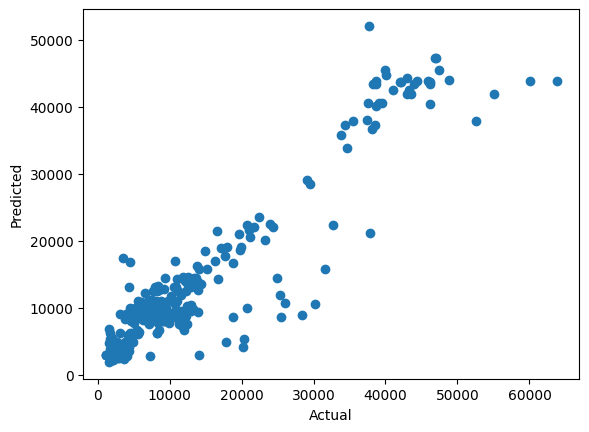

In [16]:
plt.scatter(Y_test, y_pred)
plt.xlabel("Actual")
plt.ylabel("Predicted")

<Axes: xlabel='charges'>

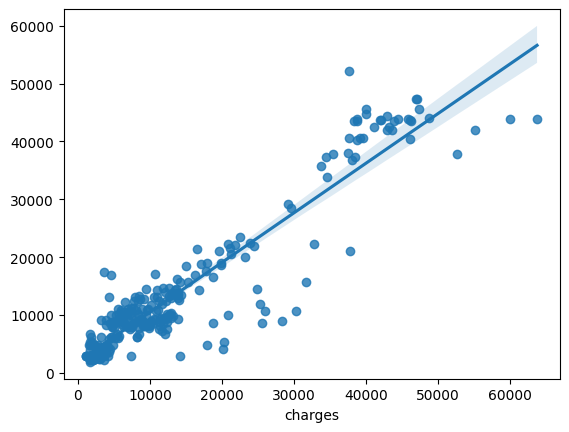

In [17]:
sns.regplot(x=Y_test, y=y_pred)

In [18]:
pred_df = pd.DataFrame({'Actual Value' : Y_test, 'Predicted Value' : y_pred})

In [19]:
pred_df

,Actual Value,Predicted Value
900,8688.85885,9348.098747
1064,5708.86700,9568.536707
1256,11436.73815,8730.039963
298,38746.35510,43831.352775
237,4463.20510,8598.111138
...,...,...
534,13831.11520,13027.910483
542,13887.20400,13887.146173
760,3925.75820,9066.834414
1284,47403.88000,45595.644653
